In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

In [6]:
# Function to get a random image from DataLoader
def get_random_image(data_loader):
    for images, _ in data_loader:
        return images[0]

    
# Define transformations
transform = transforms.ToTensor()

# Resize MNIST images to 32x32
transform_resize_mnist = transforms.Compose([
    transforms.Resize((32, 32)),
])


mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)

cifar_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 64
num_workers = 4
prefetch_factor = 2

mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, prefetch_factor=prefetch_factor)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=num_workers, prefetch_factor=prefetch_factor)
cifar10_train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=num_workers, prefetch_factor=prefetch_factor)
cifar10_test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=num_workers, prefetch_factor=prefetch_factor)


# MNIST preparation: Resize and extend channels
mnist_train_image = get_random_image(mnist_train_loader).repeat(3, 1, 1)
mnist_test_image = get_random_image(mnist_test_loader).repeat(3, 1, 1)

cifar10_train_image = get_random_image(cifar10_train_loader)
cifar10_test_image = get_random_image(cifar10_test_loader)

mnist_train_image_resized = transform_resize_mnist(mnist_train_image)#.repeat(3, 1, 1)
mnist_test_image_resized = transform_resize_mnist(mnist_test_image)#.repeat(3, 1, 1)

# Print resized MNIST shape to verify
print(f"Resized MNIST train image shape: {mnist_train_image_resized.shape}")
print(f"CIFAR-10 train image shape: {cifar10_train_image.shape}")

# Print resized MNIST shape to verify
print(f"Resized MNIST test image shape: {mnist_test_image_resized.shape}")
print(f"CIFAR-10 test image shape: {cifar10_test_image.shape}")


# Ensure both images have the same dimensions
assert mnist_train_image_resized.shape == cifar10_train_image.shape, "Images must have the same dimensions"
assert mnist_test_image_resized.shape == cifar10_test_image.shape, "Images must have the same dimensions"


# Compute the mean image
mean_train_image = (mnist_train_image_resized + cifar10_train_image) / 2
mean_test_image = (mnist_test_image_resized + cifar10_test_image) / 2

# Ensure mean_image has the correct shape: [batch_size, channels, height, width]
mean_train_image = mean_train_image.unsqueeze(0)  # Add batch dimension
mean_test_image = mean_test_image.unsqueeze(0)  # Add batch dimension

print(f"Mean train image shape: {mean_train_image.shape}")
print(f"Mean test image shape: {mean_test_image.shape}")

Files already downloaded and verified
Files already downloaded and verified
Resized MNIST train image shape: torch.Size([3, 32, 32])
CIFAR-10 train image shape: torch.Size([3, 32, 32])
Resized MNIST test image shape: torch.Size([3, 32, 32])
CIFAR-10 test image shape: torch.Size([3, 32, 32])
Mean train image shape: torch.Size([1, 3, 32, 32])
Mean test image shape: torch.Size([1, 3, 32, 32])


In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),  
            nn.BatchNorm2d(64),
            nn.Dropout(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.Dropout(0.5)
        )

        # Decoder for MNIST
        self.decoder_mnist = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 256 * 4 * 4),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

        # Decoder for CIFAR-10
        self.decoder_cifar = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 256 * 4 * 4),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed_mnist = self.decoder_mnist(latent)
        reconstructed_cifar = self.decoder_cifar(latent)
        return reconstructed_mnist, reconstructed_cifar

# Instantiate the model
autoencoder = Autoencoder()

Epoch [5/50], Loss: 0.04276588
Epoch [10/50], Loss: 0.04258306
Epoch [15/50], Loss: 0.03927524
Epoch [20/50], Loss: 0.03700652
Epoch [25/50], Loss: 0.03829560
Epoch [30/50], Loss: 0.03568356
Epoch [35/50], Loss: 0.03569143
Epoch [40/50], Loss: 0.03395462
Epoch [45/50], Loss: 0.03558225
Epoch [50/50], Loss: 0.03373291
Test Loss: 0.0284


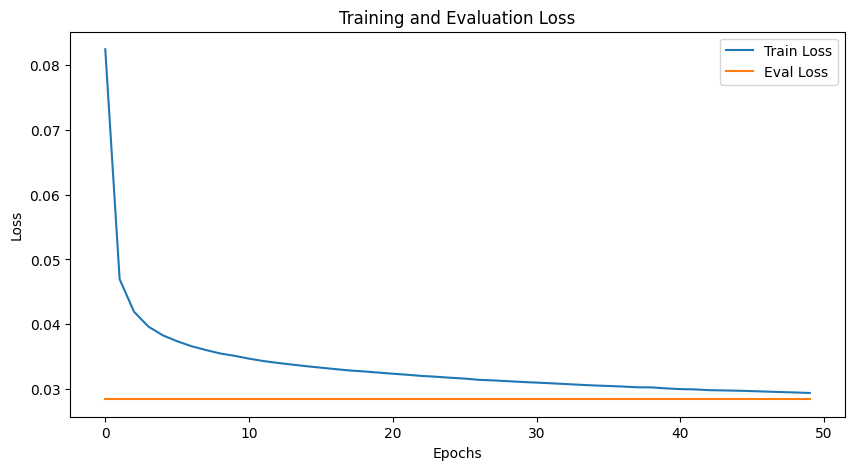

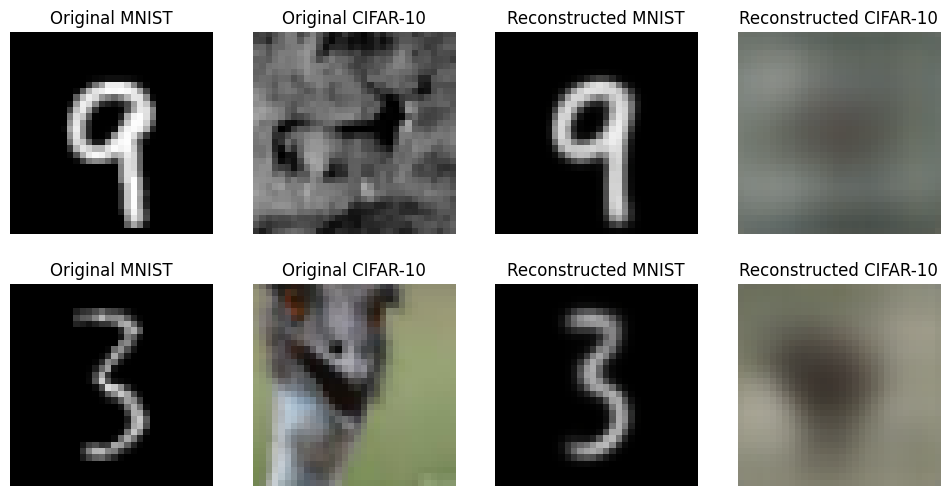

Mean SSIM (MNIST): 0.8998, Mean PSNR (MNIST): 22.54
Mean SSIM (CIFAR-10): 0.3735, Mean PSNR (CIFAR-10): 17.01


In [8]:
# Define a loss function
criterion = nn.MSELoss()

# Define an optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

# Training function
def train_model(model, mnist_loader, cifar_loader, criterion, optimizer, epochs=5):
    model.train()
    train_loss = []

    for epoch in range(epochs):
        running_loss = 0.0
        for mnist_data, cifar_data in zip(mnist_loader, cifar_loader):
            mnist_images, _ = mnist_data
            cifar_images, _ = cifar_data
            
            # Resize MNIST images and repeat channels
            mnist_images = mnist_images.repeat(1, 3, 1, 1)
            mnist_images = transform_resize_mnist(mnist_images)
            
            mean_images = (cifar_images + mnist_images) / 2
            
            # Ensure both images have the same dimensions
            assert mnist_images.shape == cifar_images.shape, "Images must have the same dimensions"

            # Move images to the device
            mnist_images = mnist_images.to(device)
            cifar_images = cifar_images.to(device)
            mean_images = mean_images.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            reconstructed_mnist, reconstructed_cifar = model(mean_images)

            # Calculate loss
            loss = criterion(reconstructed_mnist, mnist_images) + criterion(reconstructed_cifar, cifar_images)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            
        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(mnist_loader)
        train_loss.append(epoch_loss)
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.8f}')

    return train_loss


# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    eval_loss = []
    
    with torch.no_grad():
        running_loss = 0.0
        for mnist_images, cifar_images in zip(mnist_test_loader, cifar10_test_loader):
            mnist_images, _ = mnist_images
            cifar_images, _ = cifar_images

            # Resize MNIST images and repeat channels
            mnist_images = transform_resize_mnist(mnist_images)
            mnist_images = mnist_images.repeat(1, 3, 1, 1)
            
            mean_images = (cifar_images + mnist_images) / 2
            
            # Ensure both images have the same dimensions
            assert mnist_images.shape == cifar_images.shape, "Images must have the same dimensions"

            # Move images to the device
            mnist_images = mnist_images.to(device)
            cifar_images = cifar_images.to(device)
            mean_images = mean_images.to(device)

            # Forward pass
            reconstructed_mnist, reconstructed_cifar = model(mean_images)

            # Calculate loss
            loss = criterion(reconstructed_mnist, mnist_images) + criterion(reconstructed_cifar, cifar_images)
            
            # Update running loss
            running_loss += loss.item()


        # Calculate average loss for the evaluation
        eval_loss = running_loss / len(test_loader)
        print(f"Test Loss: {eval_loss:.4f}")
        
    return eval_loss


# Function to visualize the loss curves
def plot_loss(train_loss, eval_loss):
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(eval_loss, label='Eval Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss')
    plt.legend()
    plt.show()

# Function to visualize the original and reconstructed images
def visualize_reconstructions(model, test_loader):
    model.eval()
    with torch.no_grad():
        mnist_images, cifar_images = next(iter(zip(mnist_test_loader, cifar10_test_loader)))
        mnist_images, _ = mnist_images
        cifar_images, _ = cifar_images
        
        # Resize MNIST images and repeat channels
        mnist_images = transform_resize_mnist(mnist_images)
        mnist_images = mnist_images.repeat(1, 3, 1, 1)
        
        mean_images = (cifar_images + mnist_images) / 2
        
        # Ensure both images have the same dimensions
        assert mnist_images.shape == cifar_images.shape, "Images must have the same dimensions"

        # Move images to the device
        mnist_images = mnist_images.to(device)
        cifar_images = cifar_images.to(device)
        mean_images = mean_images.to(device)

        # Forward pass
        reconstructed_mnist, reconstructed_cifar = model(mean_images)

        # Move the reconstructed images back to CPU for visualization
        mnist_images = mnist_images.cpu()
        cifar_images = cifar_images.cpu()
        reconstructed_mnist = reconstructed_mnist.cpu()
        reconstructed_cifar = reconstructed_cifar.cpu()

        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        
        for i in range(2):
            axes[i, 0].imshow(mnist_images[i].permute(1, 2, 0).numpy())
            axes[i, 0].set_title('Original MNIST')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(cifar_images[i].permute(1, 2, 0).numpy())
            axes[i, 1].set_title('Original CIFAR-10')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(reconstructed_mnist[i].permute(1, 2, 0).numpy())
            axes[i, 2].set_title('Reconstructed MNIST')
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(reconstructed_cifar[i].permute(1, 2, 0).numpy())
            axes[i, 3].set_title('Reconstructed CIFAR-10')
            axes[i, 3].axis('off')
        
        plt.show()
        
        # Compute SSIM and PSNR for MNIST
        ssim_mnist_sum = 0.0
        psnr_mnist_sum = 0.0
        for i in range(len(mnist_images)):
            original_mnist_np = mnist_images[i].permute(1, 2, 0).numpy()
            reconstructed_mnist_np = reconstructed_mnist[i].permute(1, 2, 0).numpy()
            ssim_mnist_sum += ssim(original_mnist_np, reconstructed_mnist_np, channel_axis=2, win_size=7, data_range=1.0)
            psnr_mnist_sum += psnr(original_mnist_np, reconstructed_mnist_np, data_range=1.0)

        # Compute SSIM and PSNR for CIFAR-10
        ssim_cifar_sum = 0.0
        psnr_cifar_sum = 0.0
        for i in range(len(cifar_images)):
            original_cifar_np = cifar_images[i].permute(1, 2, 0).numpy()
            reconstructed_cifar_np = reconstructed_cifar[i].permute(1, 2, 0).numpy()
            ssim_cifar_sum += ssim(original_cifar_np, reconstructed_cifar_np, channel_axis=2, win_size=7, data_range=1.0)
            psnr_cifar_sum += psnr(original_cifar_np, reconstructed_cifar_np, data_range=1.0)

        # Calculate means
        num_images = len(mnist_images)
        mean_ssim_mnist = ssim_mnist_sum / num_images
        mean_psnr_mnist = psnr_mnist_sum / num_images

        num_images = len(cifar_images)
        mean_ssim_cifar = ssim_cifar_sum / num_images
        mean_psnr_cifar = psnr_cifar_sum / num_images

        print(f'Mean SSIM (MNIST): {mean_ssim_mnist:.4f}, Mean PSNR (MNIST): {mean_psnr_mnist:.2f}')
        print(f'Mean SSIM (CIFAR-10): {mean_ssim_cifar:.4f}, Mean PSNR (CIFAR-10): {mean_psnr_cifar:.2f}')
        
        

# Train the model
epochs = 50
train_loss = train_model(autoencoder, mnist_train_loader, cifar10_train_loader, criterion, optimizer, epochs)

# Evaluate the model
eval_loss = evaluate_model(autoencoder, mnist_test_loader, criterion)


# Plot the loss curves
plot_loss(train_loss, [eval_loss] * epochs)

# Visualize the original and reconstructed images
visualize_reconstructions(autoencoder, mnist_test_loader)